Imports

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import seaborn as sb

Einlesen CSV-Datei

In [2]:
df = pd.read_csv('telco_churn.csv', index_col=0, sep = ';')
df.drop(columns = 'Count', inplace = True)
df.head()

,Country,State,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Score,CLTV
CustomerID,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,United States,California,NaN,NaN,"33,964131","-118,272783",Male,No,No,No,...,No,No,No,Month-to-month,Yes,Mailed check,"53,85","108,15",86.0,3239.0
9237-HQITU,United States,California,Los Angeles,90005.0,"34,059281","-118,307420",Female,No,No,Yes,...,No,NaN,No,Month-to-month,Yes,Electronic check,"70,7","151,65",NaN,2701.0
9305-CDSKC,United States,California,Los Angeles,90006.0,"34,048013","-118,293953",Female,No,No,Yes,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,"99,65","820,5",86.0,5372.0
7892-POOKP,United States,California,Los Angeles,90010.0,"34,062125","-118,315709",Female,No,Yes,Yes,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,"104,8","3046,05",84.0,5003.0
0280-XJGEX,United States,California,Los Angeles,90015.0,"34,039224","-118,266293",Male,No,No,Yes,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),"103,7","5036,3",89.0,NaN


Zuweisung von Category, wo sinnvoll

In [3]:
df.Country = df.Country.astype('category')
df.State = df.State.astype('category')
df.City = df.City.astype('category')
df['Zip Code'] = df['Zip Code'].astype('float64')
cols = []
for i in range(6,23):
    cols.append(df.columns[i])
    for col in cols:
        df[col] = df[col].astype('category')
df['Monthly Charges'] = df['Monthly Charges'].str.replace(',','.').str.replace(' ','').astype('float64')
df['Total Charges'] = df['Total Charges'].str.replace(',','.').str.replace(' ','0').astype('float64')
df.Latitude = df.Latitude.str.replace(',','.').astype('object')
df.Longitude = df.Longitude.str.replace(',','.').astype('object')

df['Tenure Months'] = df['Tenure Months'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Country            7043 non-null   category
 1   State              6001 non-null   category
 2   City               6237 non-null   category
 3   Zip Code           5986 non-null   float64 
 4   Latitude           6081 non-null   object  
 5   Longitude          6390 non-null   object  
 6   Gender             7043 non-null   category
 7   Senior Citizen     7043 non-null   category
 8   Partner            7043 non-null   category
 9   Dependents         7043 non-null   category
 10  Tenure Months      5900 non-null   float64 
 11  Phone Service      7043 non-null   category
 12  Multiple Lines     7043 non-null   category
 13  Internet Service   6313 non-null   category
 14  Online Security    7043 non-null   category
 15  Online Backup      7043 non-null   category
 

Visualisierung

array([[<Axes: title={'center': 'Tenure Months'}>,
        <Axes: title={'center': 'Monthly Charges'}>],
       [<Axes: title={'center': 'Total Charges'}>,
        <Axes: title={'center': 'Churn Score'}>],
       [<Axes: title={'center': 'CLTV'}>, <Axes: >]], dtype=object)

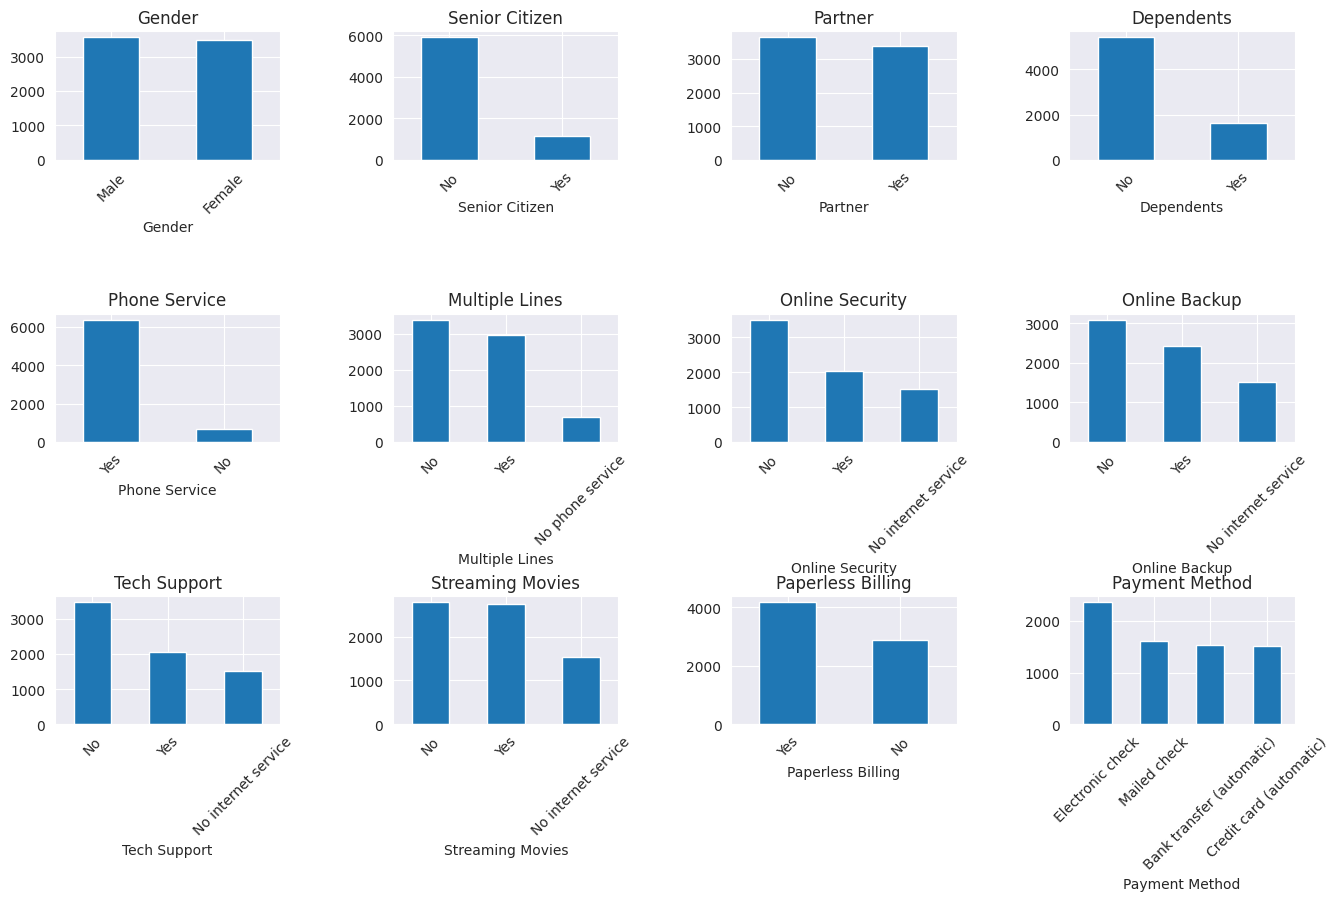

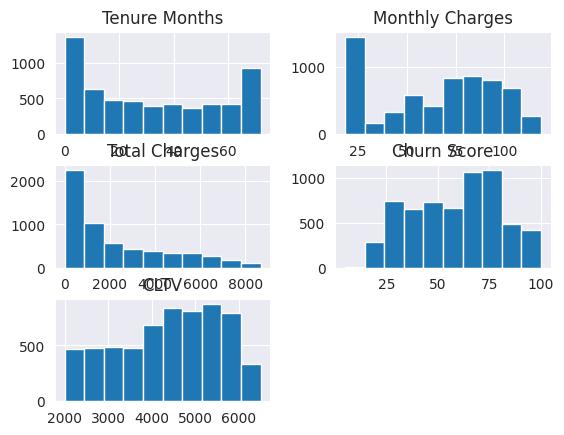

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,9))
plt.subplots_adjust(wspace=0.5, hspace=1.2)
# z zählt plots
z = 0
i = 6
for col in cols:
    if df[col].isnull().sum() == 0:
        df.iloc[:,i].value_counts().plot(ax=axes[int(z/4),z%4], kind='bar', title=df.columns[i],rot=45)
    else :
        z -= 1
    i += 1
    z += 1
dfcorr = df[['Tenure Months','Monthly Charges','Total Charges','Churn Score','CLTV']]
dfcorr.hist()

1b) Korrelationsmatrix

<Axes: >

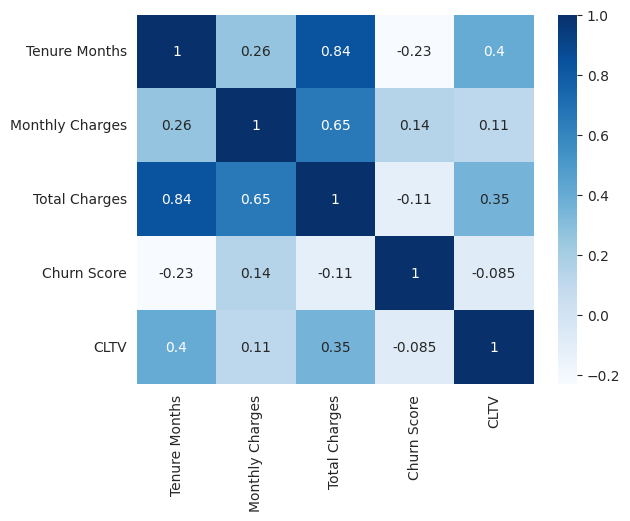

In [5]:

corr = dfcorr.corr(numeric_only=True)
sb.heatmap(corr, cmap="Blues", annot=True)


Aufgabe 2

In [6]:
df.State.fillna(value='California', inplace=True)


/tmp/ipykernel_33165/3394918993.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.State.fillna(value='California', inplace=True)


In [7]:
import time

geolocator = Nominatim(user_agent='geo_agent')

df.City = df.City.astype('object')
def get_city_and_zip(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), language="en", exactly_one=True)
        if location:
            address = location.raw.get("address", {})
            city = address.get("city", "")
            zipcode = address.get("postcode", "")
            return city, zipcode
        else:
            return "", ""
    except Exception as e:
        print(f"Error fetching data for coordinates ({lat}, {lon}): {e}")
        return "", ""

for index, row in df.iterrows():
    lat = row['Latitude']
    lon = row['Longitude']
    city, zipcode = get_city_and_zip(lat, lon)

    df.at[index, 'City'] = city
    df.at[index, 'ZipCode'] = zipcode
    time.sleep(1)




KeyboardInterrupt: 

In [7]:
mask = df['Monthly Charges'].isna() & df['Tenure Months'].gt(0) & df['Total Charges'].notna()
df.loc[mask, 'Monthly Charges'] = round(df.loc[mask, 'Total Charges'] / df.loc[mask, 'Tenure Months'],2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Country            7043 non-null   category
 1   State              7043 non-null   category
 2   City               6237 non-null   category
 3   Zip Code           5986 non-null   float64 
 4   Latitude           6081 non-null   object  
 5   Longitude          6390 non-null   object  
 6   Gender             7043 non-null   category
 7   Senior Citizen     7043 non-null   category
 8   Partner            7043 non-null   category
 9   Dependents         7043 non-null   category
 10  Tenure Months      5900 non-null   float64 
 11  Phone Service      7043 non-null   category
 12  Multiple Lines     7043 non-null   category
 13  Internet Service   6313 non-null   category
 14  Online Security    7043 non-null   category
 15  Online Backup      7043 non-null   category
 

Fix Tenure Months / Charges


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

df['Tenure Months Train'] = df['Tenure Months']
df['Total Charges Train'] = df['Total Charges']
df.reset_index(drop=True, inplace=True)

imputer = SimpleImputer(strategy='mean')
df['Total Charges Train'] = imputer.fit_transform(df[['Total Charges Train']])

dft = df[['Tenure Months Train','Total Charges Train']].dropna()
dft.columns = dft.columns.str.strip()
x_train = dft[['Total Charges Train']]
y_train = dft[['Tenure Months Train']]

model = LinearRegression()
model.fit(x_train, y_train)

missing_tenure = df['Tenure Months'].isnull()

X_missing = df.loc[missing_tenure, ['Total Charges Train']]
df.loc[missing_tenure, 'Tenure Months'] = model.predict(X_missing).round()
df.drop(columns=['Total Charges Train','Tenure Months Train'], inplace=True)




In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Country            7043 non-null   category
 1   State              7043 non-null   category
 2   City               6237 non-null   category
 3   Zip Code           5986 non-null   float64 
 4   Latitude           6081 non-null   object  
 5   Longitude          6390 non-null   object  
 6   Gender             7043 non-null   category
 7   Senior Citizen     7043 non-null   category
 8   Partner            7043 non-null   category
 9   Dependents         7043 non-null   category
 10  Tenure Months      7043 non-null   float64 
 11  Phone Service      7043 non-null   category
 12  Multiple Lines     7043 non-null   category
 13  Internet Service   6313 non-null   category
 14  Online Security    7043 non-null   category
 15  Online Backup      7043 non-null   category
 16  Device

Use Total Charges / Tenure Months to calculate Missing Monthly Charges and Tenure Months * Monthly Charges to calculate missing Total Charges


In [11]:
mask = df['Monthly Charges'].isna() & df['Tenure Months'].gt(0) & df['Total Charges'].notna()
df.loc[mask, 'Monthly Charges'] = round(df.loc[mask, 'Total Charges'] / df.loc[mask, 'Tenure Months'],2)



df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Tenure Months'] = pd.to_numeric(df['Tenure Months'], errors='coerce')
df['Monthly Charges'] = pd.to_numeric(df['Monthly Charges'], errors='coerce')

train_df = df.dropna(subset=['Monthly Charges'])

X_train = train_df[['Tenure Months']]
y_train = train_df['Monthly Charges']

model = LinearRegression()
model.fit(X_train, y_train)  

missing_mask = df['Monthly Charges'].isna()
df.loc[missing_mask, 'Monthly Charges'] = model.predict(df.loc[missing_mask, ['Tenure Months']]).round(2)

total_charges_missing = df['Total Charges'].isna()
df.loc[total_charges_missing, 'Total Charges'] = df.loc[total_charges_missing, 'Monthly Charges'] * df.loc[total_charges_missing, 'Tenure Months']
df.to_csv('test.csv', index=False)


Internet Service

In [147]:
cols =['Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']
dfi = df[cols]

for index, row in dfi.iterrows():
    if row['Online Security'] == "No internet service":
        dfi.loc[index] = dfi.loc[index].fillna("No internet service")


print(dfi.isna().sum())
dfi.info()
dfi.head(10)

TypeError: Cannot setitem on a Categorical with a new category (No internet service), set the categories first

In [166]:
zero_count = (df['Total Charges'].isna()).sum()

print("Number of zeros in 'monthly_charges':", zero_count)


Number of zeros in 'monthly_charges': 0
